Supplementary Fig.: GPCCA and fate probabilities extract the essence of cellular state transitions
----
Illustrates the concept of the GPCCA algorithm using a toy data example. 

# Preliminaries

## Import packages

In [1]:
# import standard packages
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# two extra imports here, pydtmc is for Markov chains, networkx helps us with graph visualization
import pydtmc
import networkx as nx

# import single-cell packages
import scanpy as sc
import scanpy.external as sce
import scvelo as scv
import cellrank as cr

# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 2
scv.settings.verbosity = 3 

## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [2]:
cr.logging.print_versions()

cellrank==1.0.0+gb3e00a8 scanpy==1.6.0 anndata==0.7.4 numpy==1.19.2 numba==0.51.2 scipy==1.5.2 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.3 scvelo==0.2.2 pygam==0.8.0 matplotlib==3.3.2 seaborn==0.11.0


In [3]:
cr.logging.print_version_and_date()

Running CellRank 1.0.0+gb3e00a8, on 2020-10-17 14:01.


## Set up paths

Define the paths to load data, cache results and write figure panels.

In [4]:
sys.path.insert(0, "../..")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, CACHE_DIR, FIG_DIR

We're only saving into a single directory here:

In [5]:
FIG_DIR = FIG_DIR / "suppl_fig_GPCCA"

Set up the paths to save figures.

In [6]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)
cr.settings.figdir = str(FIG_DIR)

## Set global parameters

Set some plotting parameters.

In [7]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')
scv.settings.plot_prefix = ""

Set other global parameters

In [8]:
# should figures just be displayed or also saved?
save_figure = True

If there are other global parameters for this analysis, put them here as well. 

# Apply GPCCA to toy example

## Set up Markov chain

In [9]:
p = np.array([
    # 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   10.  11.   
    [0.0, 0.8, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], #0
    [0.2, 0.0, 0.6, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], #1
    [0.6, 0.2, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], #2
    
    [0.0, 0.05, 0.05, 0.0, 0.6, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], #3
    [0.0, 0.0, 0.0, 0.25, 0.0, 0.25, 0.4, 0.0, 0.0, 0.1, 0.0, 0.0], #4
    [0.0, 0.0, 0.0, 0.25, 0.25, 0.0, 0.1, 0.0, 0.0, 0.4, 0.0, 0.0], #5
    
    [0.0, 0.0, 0.0, 0.0, 0.05, 0.05, 0.0, 0.7, 0.2, 0.0, 0.0, 0.0], #6
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.8, 0.0, 0.0, 0.0], #7
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.2, 0.0, 0.0, 0.0, 0.0], #8
    
    [0.0, 0.0, 0.0, 0.0, 0.05, 0.05, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2], #9
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.8], #10
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.2, 0.0], #11
            ])

In [10]:
states = np.arange(p.shape[1]).astype('str')
mc = pydtmc.MarkovChain(p, states)
print(mc)


DISCRETE-TIME MARKOV CHAIN
 SIZE:           12
 CLASSES:        1
  > RECURRENT:   1
  > TRANSIENT:   0
 ERGODIC:        YES
  > APERIODIC:   YES
  > IRREDUCIBLE: YES
 ABSORBING:      NO
 REGULAR:        NO
 REVERSIBLE:     NO
 SYMMETRIC:      NO



## Visualise the state space

Plot the directed graph:

Creating graph
    Finish (0:00:00)
Embedding graph using `'fruchterman_reingold_layout'` layout
    Finish (0:00:00)


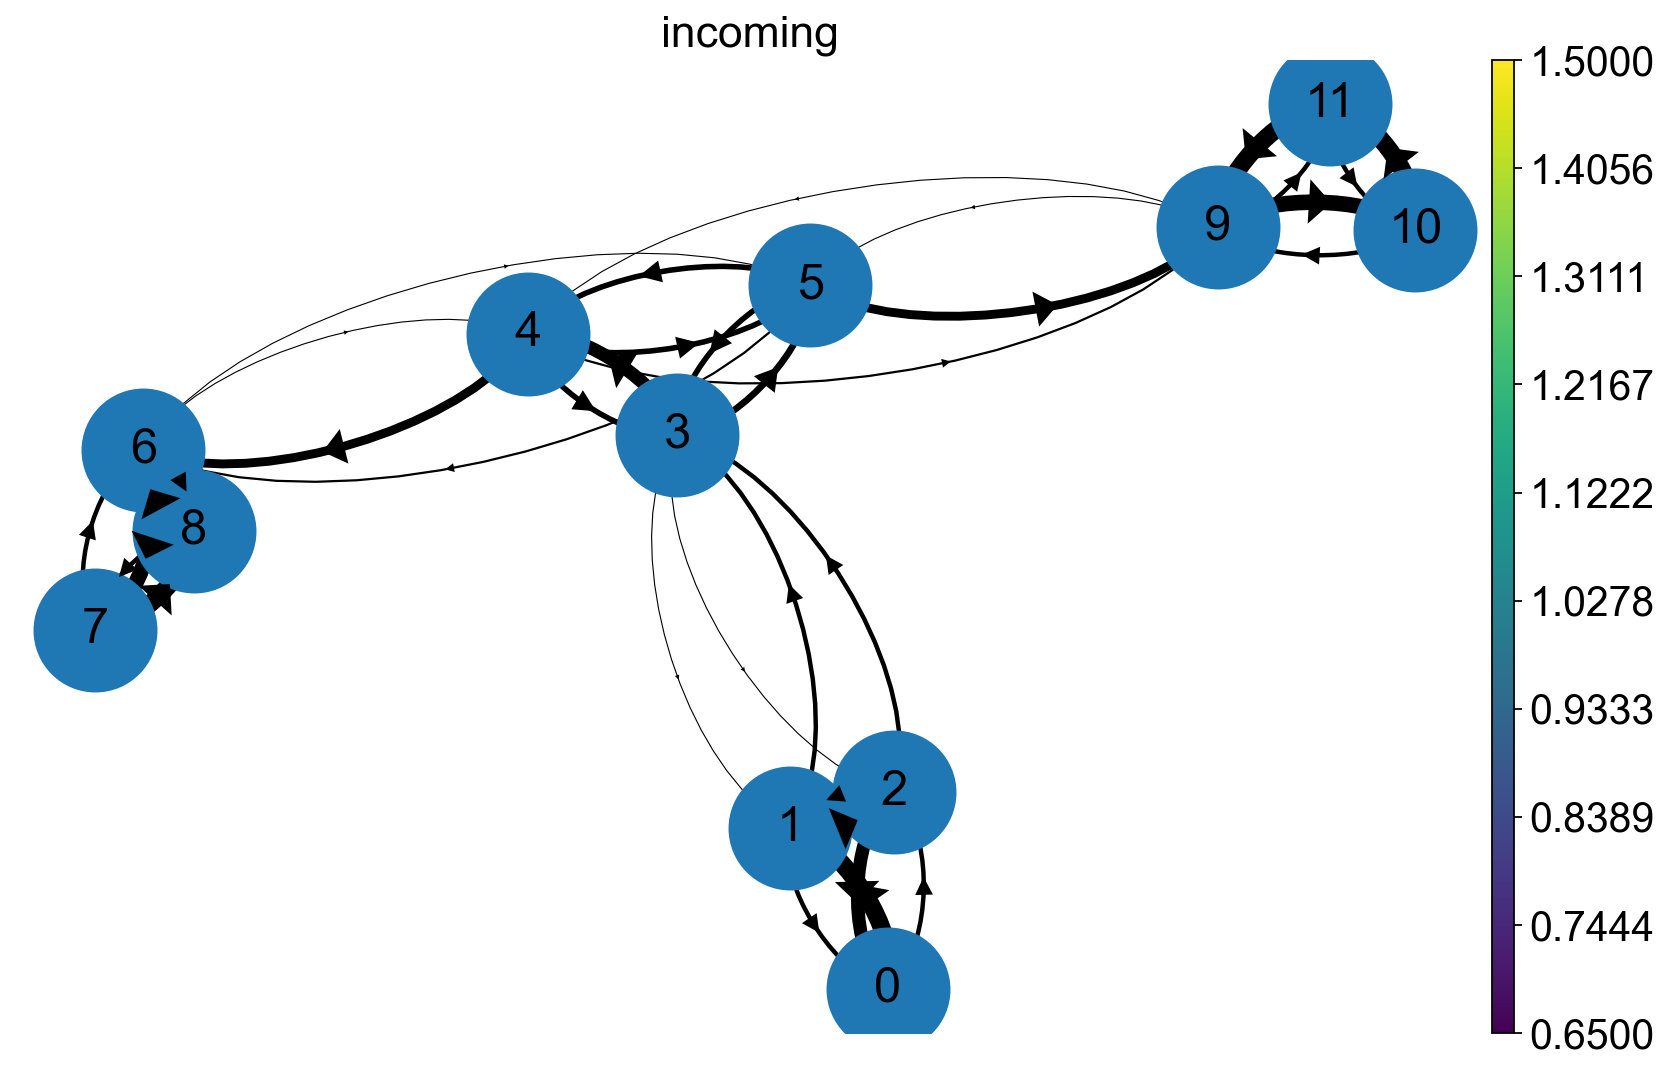

In [11]:
fig_kwargs = {'self_loops': False, 
              'self_loop_radius_frac': 0.05, 
              'labels': states, 
              'layout': nx.layout.spring_layout, 
              'color_nodes': False, 
              'node_size': 3000, 
              'edge_weight_scale': 10, 
              'font_size': 22, 
              'edge_width_limit': 10}
if save_figure: fig_kwargs['save'] = 'graph.pdf'
cr.pl.graph(p, **fig_kwargs)

## Create a kernel object

In [12]:
# import precomputed kernel calss and initialise object
from cellrank.tl.kernels import PrecomputedKernel
pk = PrecomputedKernel(p)

# modify the underlying anndata object, provide state names and clustering
pk._adata.obs_names = states
annot = ['initial', 'initial', 'initial', 'interm', 'interm', 'interm', 'terminal_1', 'terminal_1', 'terminal_1', 
         'terminal_2', 'terminal_2', 'terminal_2']
pk._adata.obs['clusters'] = pd.Series(index=pk._adata.obs_names, data=annot, dtype='category')

Create a cellrank GPCCA object. This is a bit hacky, because we need a dummy adata object:

In [13]:
g_cr = cr.tl.estimators.GPCCA(pk)

## Visualise the transition matrix

Visualise the transition matrix in a heatmap, using the estimator object

Computing eigendecomposition of the transition matrix
Adding `.eigendecomposition`
       `adata.uns['eig_fwd']`
    Finish (0:00:00)


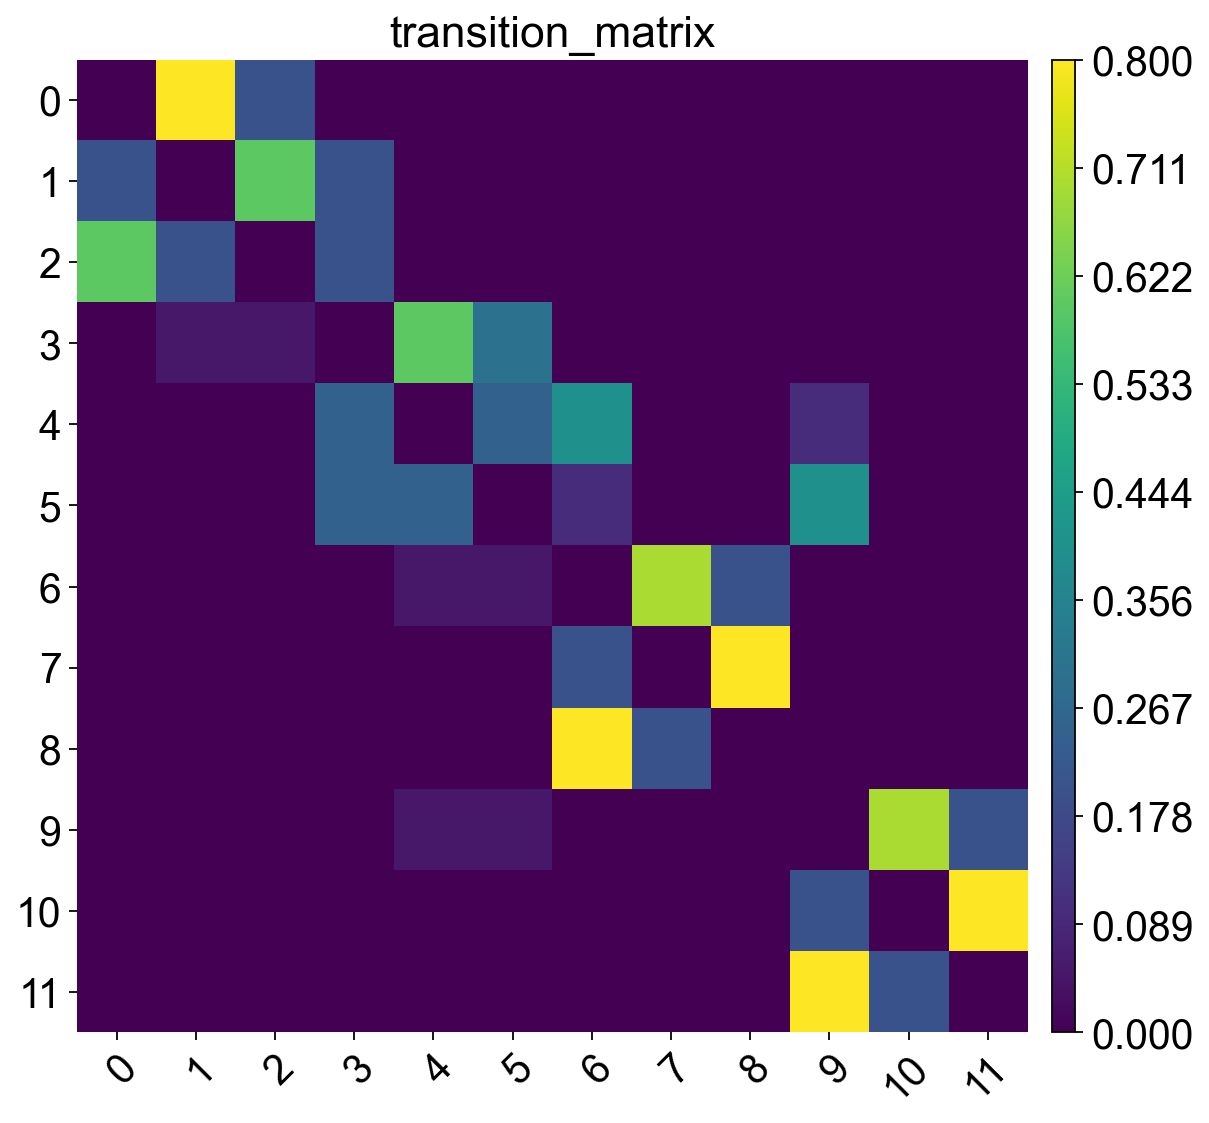

In [14]:
g_cr.compute_eigendecomposition(k = 5)

g_dummy = cr.tl.estimators.GPCCA(pk)
g_dummy._coarse_T = pd.DataFrame(p, index=states, columns=states)
g_dummy._coarse_stat_dist = pd.Series(index=states, data=g_cr.eigendecomposition['stationary_dist'])

fig_kwargs = {'title': 'transition_matrix', 
              'annotate': False, 
              'figsize': (8, 8), 
              'show_stationary_dist': False}
if save_figure: fig_kwargs['save'] = 'transition_matrix.pdf'
g_dummy.plot_coarse_T(**fig_kwargs)

## Decompose into macrostates

Compute schur decomposition and plot the top eigenvalues:

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[7, 9, 11]`
Adding `.eigendecomposition`
       `adata.uns['eig_fwd']`
       `.schur`
       `.schur_matrix`
    Finish (0:00:01)


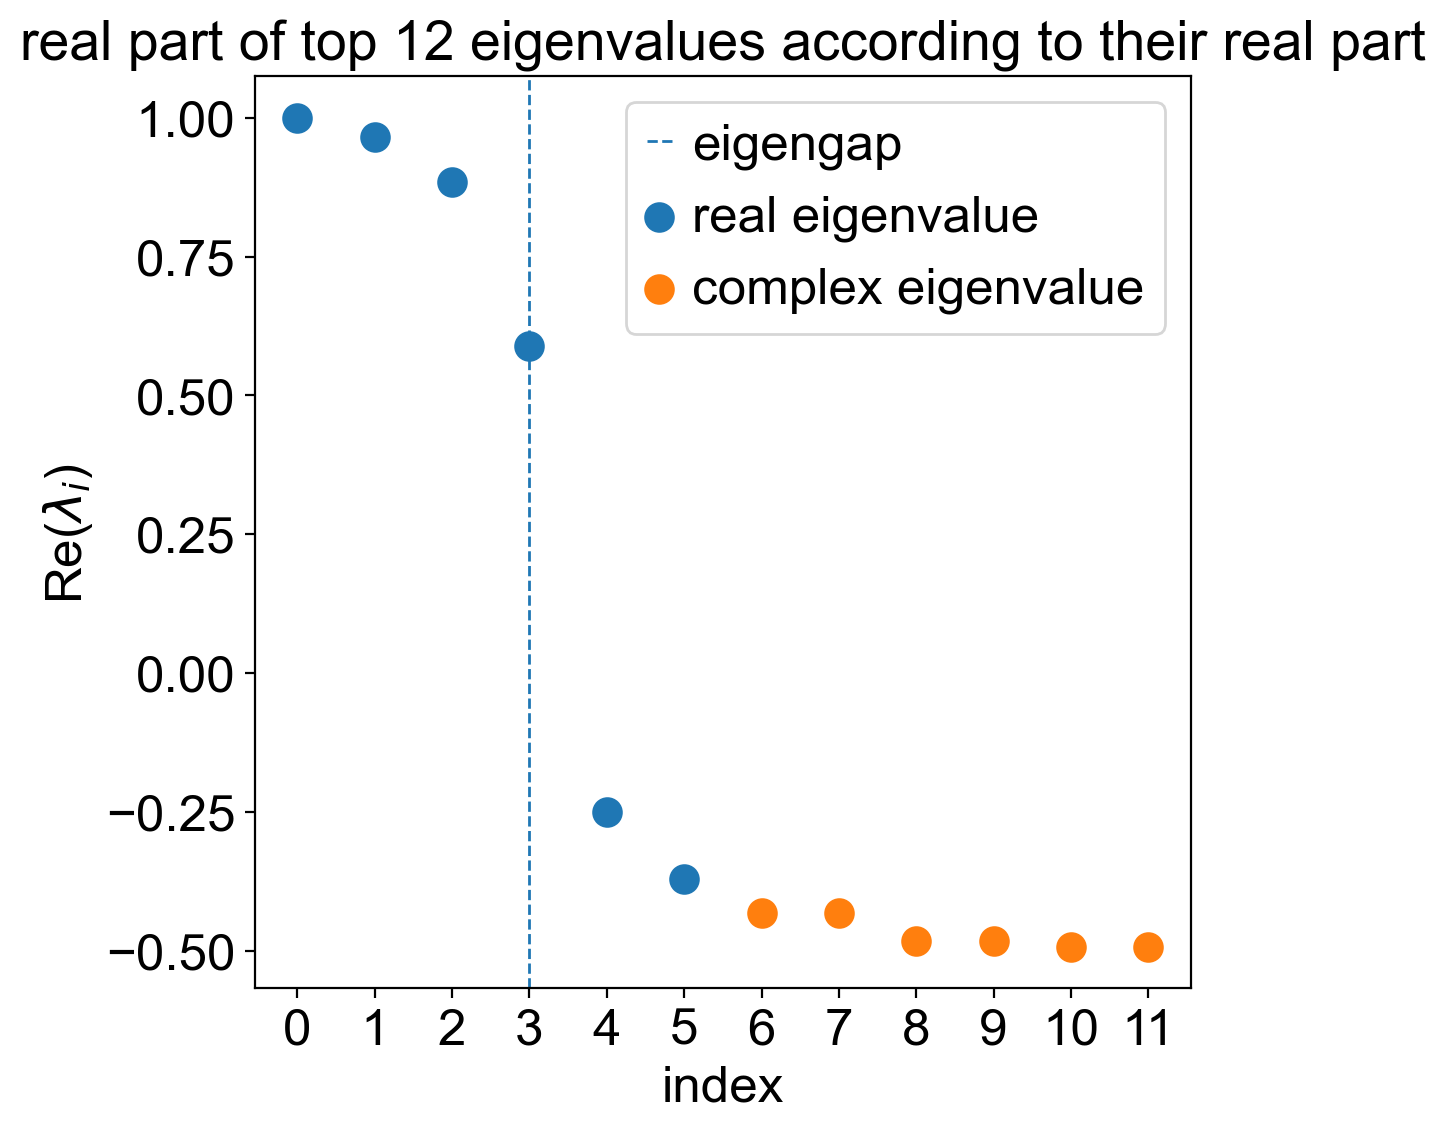

In [15]:
g_cr.compute_schur(method='krylov', n_components=12, which='LR')

fig_kwargs = {'real_only': True, 'marker': 'o', 's': 100, 'figsize': (6, 6)}
if save_figure: fig_kwargs['save'] = 'spectrum.pdf'
g_cr.plot_spectrum(**fig_kwargs)

In [16]:
n_states = 4
n_cells = 3

g_cr.compute_macrostates(n_states=n_states, n_cells=n_cells, cluster_key='clusters')

Computing `4` macrostates
INFO: Using pre-computed schur decomposition
Adding `.macrostates_memberships`
       `.macrostates`
       `.schur`
       `.coarse_T`
       `.coarse_stationary_distribution`
    Finish (0:00:00)


Automatically determine the terminal states and show their names:

In [17]:
g_cr.compute_terminal_states(n_cells=n_cells, method='stability')

# check that we got the right ones
terminal_names = list(g_cr.terminal_states.cat.categories)
assert(terminal_names == ['terminal_2', 'terminal_1'])
print(f"Identified the following terminal states: {terminal_names}")

Adding `adata.obs['terminal_states_probs']`
       `adata.obs['terminal_states']`
       `adata.obsm['macrostates_fwd']`
       `.terminal_states_probabilities`
       `.terminal_states`
Identified the following terminal states: ['terminal_2', 'terminal_1']


## Show macrostate memberships

Show assignments to macrostates

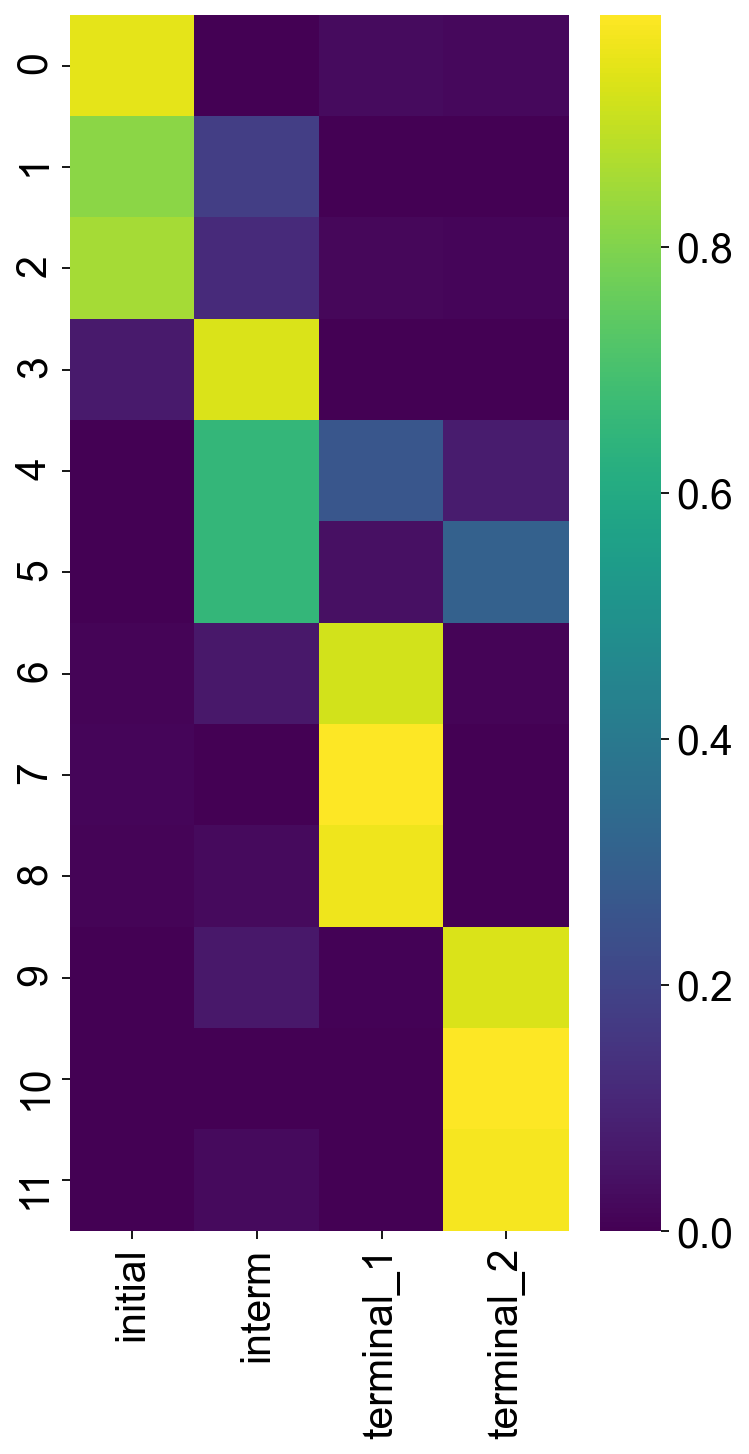

In [18]:
macro_names = ['initial', 'interm', 'terminal_1', 'terminal_2']

m_g = g_cr._macrostates_memberships[macro_names]
sns.heatmap(m_g, robust=True, annot=False, ax=plt.figure(None, (5, 10)).gca(), fmt='.2f',
           cmap='viridis', xticklabels=m_g.names)
if save_figure:
    plt.savefig(FIG_DIR / "membership_matrix.pdf")
plt.show()

## Show the coarse-grained transition matrix

Plot the coarse-grained transition matrix:

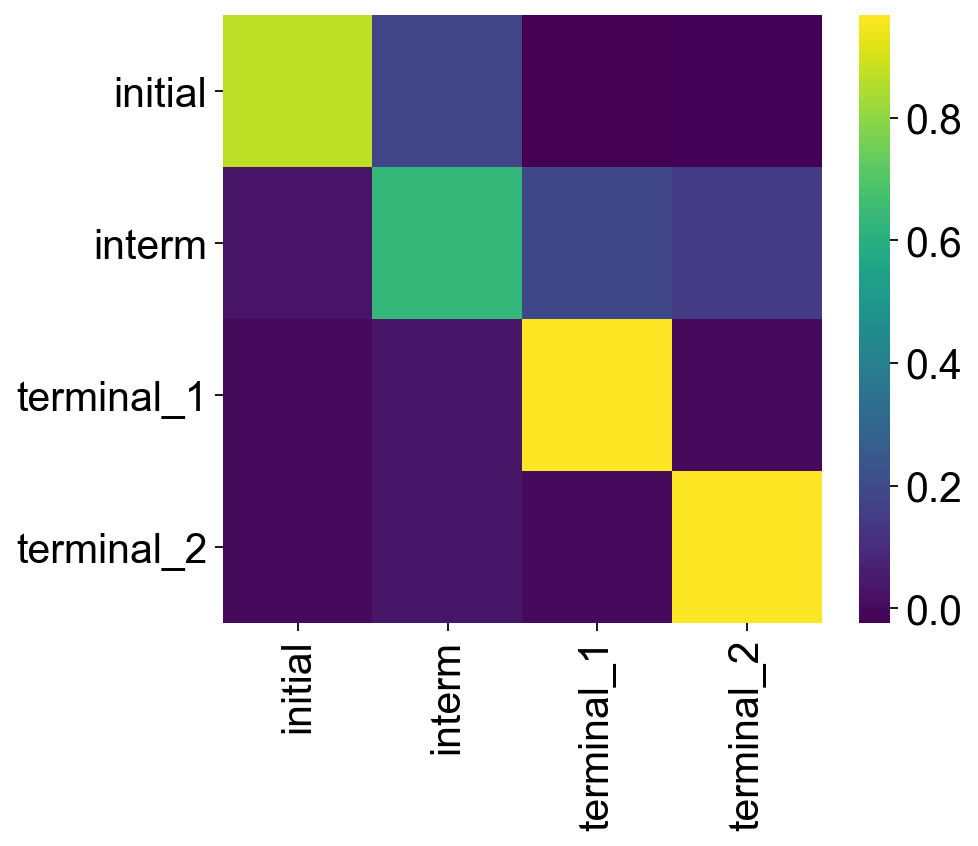

In [19]:
T_coarse = g_cr.coarse_T

fig = plt.figure(None, (6, 5))
ax = fig.add_subplot(111)
sns.heatmap(T_coarse[macro_names].loc[macro_names], cmap='viridis')
if save_figure:
    plt.savefig(FIG_DIR / "t_coarse.pdf")
plt.show()

## Compute and show fate probabilities

Compute absorption probabilities towards the two terminal states:

Computing absorption probabilities
Adding `adata.obsm['to_terminal_states']`
       `adata.obs['to_terminal_states_dp']`
       `.absorption_probabilities`
       `.diff_potential`
    Finish (0:00:00)


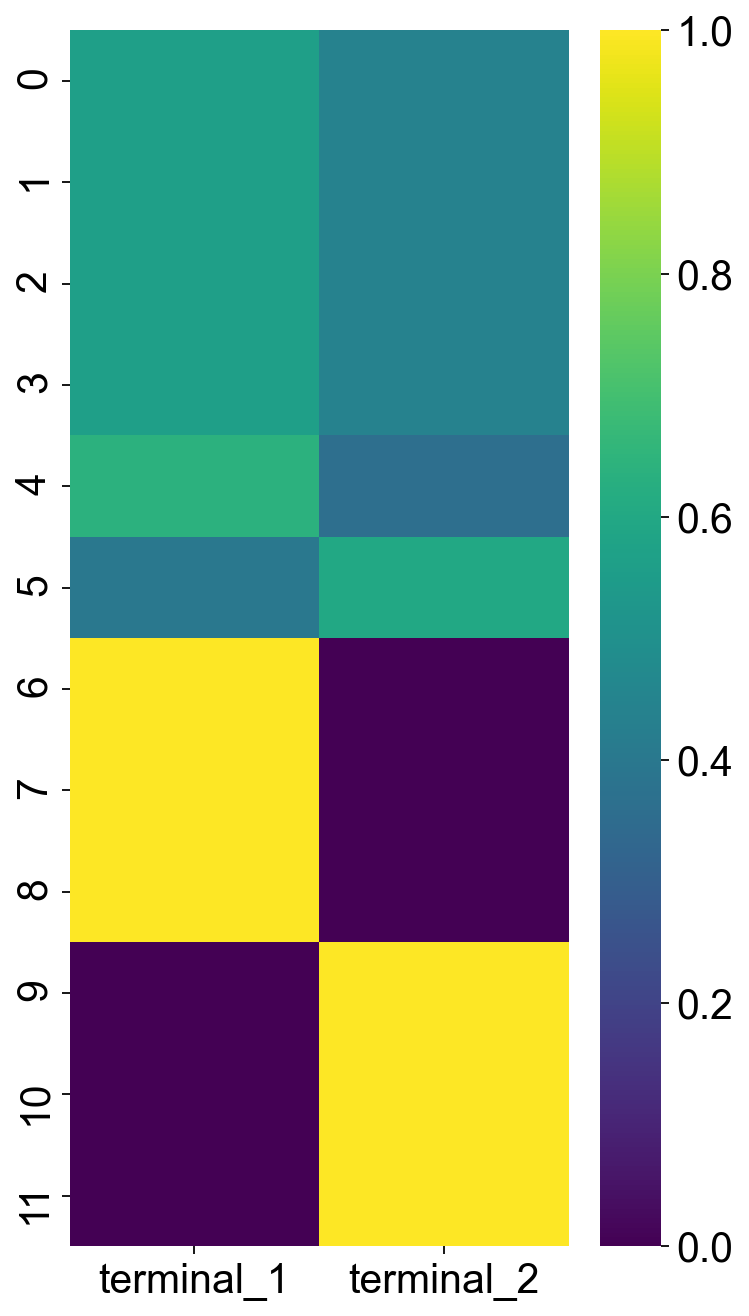

In [20]:
g_cr.compute_absorption_probabilities()
m_c = g_cr.absorption_probabilities[['terminal_1', 'terminal_2']]
sns.heatmap(m_c, robust=True, annot=False, ax=plt.figure(None, (5, 10)).gca(), fmt='.2f',
           cmap='viridis', xticklabels=m_c.names)
if save_figure:
    plt.savefig(FIG_DIR / "fate_probs.pdf")
plt.show()